In [73]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
# from scipy.spatial.distance import pdist
from torch.utils.data import DataLoader, Dataset, random_split



In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

## MD step function

In [10]:
def energy_lj(r: torch.tensor, epsilon: float = 1.0, sigma: float = 1.0):
    """Compute the Lennard-Jones energy of a system with positions r

    Parameters
    ----------
    r: atomic configuration

    sigma: LJ potential parameter sigma, default 1.0

    epsilon: LJ potential parameter epsilon, default 1.0

    Return
    ------
    ene: total LJ energy of atomic configuration

    """
    def lj(dist, epsilon: float = 1.0, sigma: float = 1.0):
        return 4 * epsilon * ((sigma / dist)**12 - (sigma / dist)**6)

    distances = F.pdist(r)

    pair_energies = torch.vmap(lj)(distances)

    return torch.sum(pair_energies)

In [11]:
def get_forces(energy_fn, r: torch.Tensor):

    """Computes the forces acting on a configuration r for a given energy function using backpropagation.

    Parameters
    ----------
    r: atomic configuration

    energy_fn: energy function


    Return
    ------
    f: atomic forces
    """

    assert r.requires_grad == False

    r.requires_grad = True

    # evaluate energy
    energy = energy_fn(r)

    # compute gradients w.r.t. r
    energy.backward()

    # get gradients w.r.t. r
    forces = -r.grad

    r.requires_grad = False
    return forces

In [12]:
def verlet_step(
    r: torch.tensor,
    v: torch.tensor,
    f: torch.tensor,
    energy_fn: callable,
    dt: float,
    m: float = 1.0,
):
    """velocity Verlet step: MD in NVE ensemble.

    Parameters
    ----------
    r: positions

    v: velocities

    f: forces

    dt: time step

    m: mass

    energy_fn: energy function

    Return
    ------
    r: updated position

    v: updated velocities

    f: updated forces


    """
    # Remove center of mass motion
    com = torch.mean(v, axis=0)
    v -= com

    # update velocity 1/2 step
    v += 0.5 * f / m * dt

    # update positions
    r = r + v * dt

    f = get_forces(energy_fn, r)

    # update velocity 1/2 step
    v += 0.5 * f / m * dt

    return r, v, f


## Example MD run

In [13]:
d = 1.1

# 3d cluster
clus3d = torch.tensor(
    [
        [0.0, 0.0, 0.0],
        [d / np.sqrt(2.), d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), d / np.sqrt(2), 0.0],
        [d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [0, 0, d],
        [0, 0, -d],
    ],dtype=torch.float32
)

In [14]:
def assign_MBv(n_particles, beta, m: float = 1.0):
    """Assign Maxwell-Boltzmann distributed velocities.

    Parameters
    ----------
    v: velocity array

    beta: 1/ (kB * T)

    m: atomic mass


    Return
    ------
    v:     velocity array

    """

    v = torch.normal(mean=0, std=np.sqrt(1.0 / (beta * m)), size=(n_particles, 3))

    return v

In [15]:
r = torch.clone(clus3d)

n_particles = len(r)

# compute LJ energy
energy = energy_lj(clus3d)

# set inverse temp \beta = 1 / (kB * T)
beta = 100.0
m = 1.0

dt = 1e-3
n_dimensions = r.shape[-1]

In [40]:
# initialize number of MD steps
n_steps = 100000

n_log = 50

# energies
potential_energies = torch.empty((n_steps // n_log, 1))
kinetic_energies = torch.empty((n_steps // n_log, 1))
positions = torch.empty((n_steps // n_log, n_particles, n_dimensions))

In [41]:
# assign intial structure
r = torch.clone(clus3d)

# assign intial MB velocities
v = assign_MBv(n_particles, beta, m)

# compute initial forces
f = get_forces(energy_lj, r)


In [42]:
# run velocity Verlet
num_particles = len(v)

for i in range(n_steps):
    if i % n_log == 0:
        positions[i // n_log] = r
        potential_energies[i // n_log] = energy_lj(r)
        kinetic_energies[i // n_log] = .5 * (m * num_particles) * (v ** 2).sum()

    r, v, f = verlet_step(r, v, f, energy_lj, dt, m)

In [38]:
len(v)

7

Text(0.5, 1.0, 'Histogram of Potential Energies from first simulation')

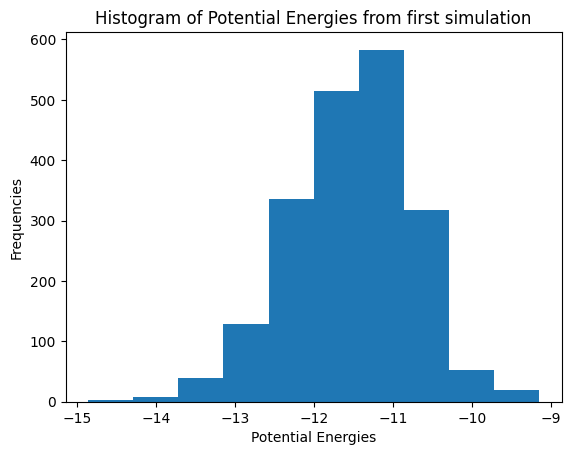

In [43]:
plt.hist(potential_energies)
plt.xlabel('Potential Energies')
plt.ylabel('Frequencies')
plt.title('Histogram of Potential Energies from first simulation')

Text(0.5, 1.0, 'Potential Energy over time for first simulation')

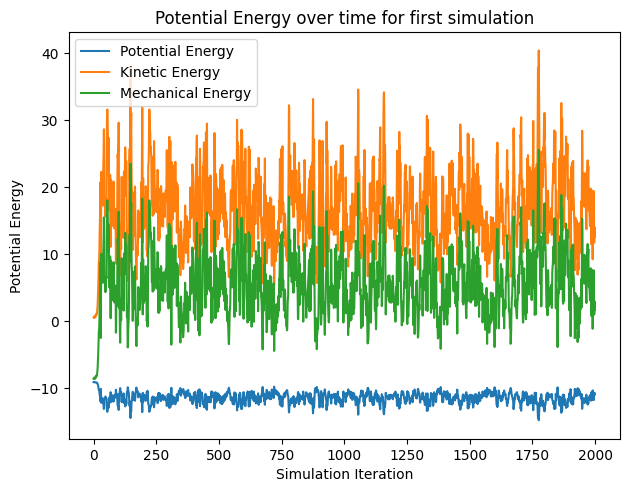

In [50]:
plt.plot(potential_energies, label="Potential Energy")
plt.plot(kinetic_energies, label="Kinetic Energy")
plt.plot(potential_energies + kinetic_energies, label="Mechanical Energy")


plt.xlabel('Simulation Iteration')
plt.ylabel('Potential Energy')
plt.legend()
plt.tight_layout()
plt.title('Potential Energy over time for first simulation')

In [77]:
# 1.2

# distances = sorted(pdist(positions[0].numpy(), metric='euclidean')) # There's probably a way to do this with cdist and avoiding using numpy
# distances

sorted_pairwise_distances = [torch.sort(F.pdist(position_set))[0] for position_set in positions]
sorted_pairwise_distances[0][0]

tensor(1.1000)

In [ ]:
class PairwiseDistanceDataset(Dataset):
    def __init__(self, positions, energies):
        self.features = [torch.sort(F.pdist(position_set))[0] for position_set in positions]
        self.labels = energies.view(-1, 1)  # Ensure labels have shape (n_samples, 1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [ ]:

dataset = PairwiseDistanceDataset(sorted_pairwise_distances, potential_energies)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)


tensor([[0.0000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000],
        [1.1000, 0.0000, 1.5556, 1.5556, 2.2000, 1.5556, 1.5556],
        [1.1000, 1.5556, 0.0000, 2.2000, 1.5556, 1.5556, 1.5556],
        [1.1000, 1.5556, 2.2000, 0.0000, 1.5556, 1.5556, 1.5556],
        [1.1000, 2.2000, 1.5556, 1.5556, 0.0000, 1.5556, 1.5556],
        [1.1000, 1.5556, 1.5556, 1.5556, 1.5556, 0.0000, 2.2000],
        [1.1000, 1.5556, 1.5556, 1.5556, 1.5556, 2.2000, 0.0000]])

In [30]:
v

tensor([[ 0.1187, -0.6924, -0.2015],
        [ 0.0226,  0.0747,  0.7524],
        [-0.5557, -1.1325,  0.5042],
        [ 0.0951,  0.7728, -0.6006],
        [-0.6018, -0.0681, -0.4486],
        [ 0.9866,  0.0951, -0.5681],
        [-0.0656,  0.9503,  0.5623]])